In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gym
import numpy as np
import tensorflow as tf
from policy_net_breakout import Policy_net
from discriminator_breakout import Discriminator
from ppo_breakout import PPOTrain
from PIL import Image
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\Anaconda3_Reinstall\envs\atari_

In [2]:
obs_state_shape = [84,84,4]
env = gym.make('Breakout-v0')
target_score = 16
# batch_size =128
#batch_size = 64
batch_size = 32
# d_step = 10
# a_step = 5
d_step = 1
a_step = 3
# d_step = 2
# a_step = 6

In [3]:
logdir = 'log/train/gail'
savedir = 'trained_models/gail'
gamma = 0.99
numepisodes = int(1e3)

In [4]:
# preprocess to feed placeholder Policy.input_normalized
def preprocess_obs_state(obs):
    obs = np.resize(obs , (84,84,4))
    obs = np.stack([obs]).astype(dtype=np.float32)
    return obs

In [5]:
def main():
    env.seed(0)
    ob_space = env.observation_space
    Policy = Policy_net('policy', env)
    Old_Policy = Policy_net('old_policy', env)
    PPO = PPOTrain(Policy, Old_Policy, gamma)
    D = Discriminator(env)

    expert_path = "expert_trajectory/expert_breakout_v0.npz"
    expert_traj_data = np.load(expert_path)
    expert_observations = expert_traj_data["obs"]
    expert_actions = expert_traj_data["actions"]
    expert_rewards = expert_traj_data["rewards"]
    expert_episode_returns = expert_traj_data["episode_returns"]
    expert_episode_starts = expert_traj_data["episode_starts"]


    sum_rewardsperepisode_list = []

    rewards_wndw = deque(maxlen=100) #last 100 scores

    #saver = tf.train.Saver()
    saver = tf.compat.v1.train.Saver()

    with tf.Session() as sess:
        #writer = tf.summary.FileWriter(args.logdir, sess.graph)
        writer = tf.compat.v1.summary.FileWriter(logdir, sess.graph)
        sess.run(tf.global_variables_initializer())

        obs = env.reset()
        reward = 0  # do NOT use rewards to update policy
        success_num = 0

        for iteration in range(numepisodes):
            observations = []
            actions = []
            rewards = []
            v_preds = []
            run_policy_steps = 0
            reward = 0
            while True:
                run_policy_steps += 1
                obs = preprocess_obs_state(obs)
                act, v_pred = Policy.act(obs=obs)
                act = np.asscalar(act)
                v_pred = np.asscalar(v_pred)

                observations.append(obs)
                actions.append(act)
                rewards.append(reward)
                v_preds.append(v_pred)

                next_obs, reward, done, info = env.step(act)
                #next_obs = preprocess_obs_state(next_obs)
                env.render()
                if done:
                    v_preds_next = v_preds[1:] + [0]  # next state of terminate state has 0 state value
                    obs = env.reset()
                    break
                else:
                    obs = next_obs

            writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag='episode_length', simple_value=run_policy_steps)])
                               , iteration)
            writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag='episode_reward', simple_value=sum(rewards))])
                               , iteration)

            render = True

            #print(" TOTAL REWARDS IN EPISODE "+ str(iteration) + " : "  + str(sum(rewards)))

            sum_rewardsperepisode_list.append(sum(rewards))
            rewards_wndw.append(sum(rewards))
            
            #print('\rEpisode {}\tAverage Score: {:.2f}'.format(iteration, np.mean(rewards_wndw)), end="")

            if(iteration%100 == 0 and iteration > 0 ):
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(iteration, np.mean(rewards_wndw)))
                saver.save(sess, savedir + '/GAIL_model_breakout-v0-'+str(iteration) +'.ckpt')
            if (np.mean(rewards_wndw)>= target_score) :
                saver.save(sess, savedir + '/GAIL_model_breakout-v0-best.ckpt')
                print('Target Score of 16 reached consistently over a range of 100 episodes. Model saved.')


            # convert list to numpy array for feeding tf.placeholder
            observations = np.reshape(observations, [-1] + obs_state_shape)
            observations = np.array(observations).astype(dtype=np.float32)

            actions = np.array(actions).astype(dtype=np.int32)

            # print("expert_observations shape >>>>>>>>>>>>>>>>>> ::::"  + str(expert_observations.shape))

            # #print(expert_observations)

            # print("expert_actions shape >>>>>>>>>>>>>>>>>> ::::"  + str(expert_actions.shape))

            # print("agent_observations shape >>>>>>>>>>>>>>>>>> ::::"  + str(observations.shape))

            # print("agent_actions shape >>>>>>>>>>>>>>>>>> ::::"  + str(actions.shape))

            # train discriminator

            discriminator_expert_inp = [expert_observations,expert_actions]

            #print(" expert_observations shape ::: " + str(expert_observations.shape))

            discriminator_agent_inp = [observations,actions]

            #print(" agent observations shape ::: " + str(observations.shape))

            for i in range(d_step):
                # Sample Expert Trajectory State - Action training data
                # discriminator_expert_sample_indices = np.random.randint(low=0, high=expert_observations.shape[0],
                #                                    size=batch_size)  # indices are in [low, high)

                discriminator_expert_sample_indices = np.random.randint(low=0, high=discriminator_expert_inp[0].shape[0],
                                                   size=batch_size)  # indices are in [low, high)

                #print("discriminator_expert_sample_indices ::" + str(discriminator_expert_sample_indices))

                sampled_expert_observation_imgpath_list = []
                
                sampled_expert_observation_nparr_list = []

                sampled_expert_action_nparr_list = []
                
                # for i in range(len(expert_observations)):
                for i in range(len(discriminator_expert_inp[0])):
                    for j in range(len(discriminator_expert_sample_indices)):
                        if(i==j):
                            # img= Image.open("ml-engineer-testing-task-data/ml-engineer-testing-task/data/" +expert_observations[i])
                            sampled_expert_observation_imgpath_list.append(discriminator_expert_inp[0][i])
                            img= Image.open("ml-engineer-testing-task-data/ml-engineer-testing-task/data/" +discriminator_expert_inp[0][i])
                            np_img = np.resize(img , (84,84,4))
                            sampled_expert_observation_nparr_list.append(np_img)

                sampled_expert_observation_nparr_list = np.array(sampled_expert_observation_nparr_list)

                sampled_expert_observation_imgpath_list = np.array(sampled_expert_observation_imgpath_list)

                # for i in range(len(expert_actions)):
                for i in range(len(discriminator_expert_inp[1])):
                    for j in range(len(discriminator_expert_sample_indices)):
                        if(i==j):
                            # sampled_expert_action_nparr_list.append(expert_actions[i])
                            sampled_expert_action_nparr_list.append(discriminator_expert_inp[1][i])

                sampled_expert_action_nparr_list = np.array(sampled_expert_action_nparr_list)
                
                discriminator_expert_sampled_inp = [sampled_expert_observation_nparr_list , sampled_expert_action_nparr_list] 

                # Sample Agent State - Action training data
                # discriminator_agent_sample_indices = np.random.randint(low=0, high=observations.shape[0],
                #                                    size=batch_size)  # indices are in [low, high)
                discriminator_agent_sample_indices = np.random.randint(low=0, high=discriminator_agent_inp[0].shape[0],
                                                   size=batch_size)  # indices are in [low, high)
                discriminator_agent_sampled_inp = [np.take(a=a, indices=discriminator_agent_sample_indices, axis=0) for a in discriminator_agent_inp] 
                
                # print("discriminator sampled expert_observations shape >>>>>>>>>>>>>>>>>> ::::"  + str(discriminator_expert_sampled_inp[0].shape))

                # print("discriminator sampled expert_actions shape >>>>>>>>>>>>>>>>>> ::::"  + str(discriminator_expert_sampled_inp[1].shape))

                # print("discriminator sampled agent_observations shape >>>>>>>>>>>>>>>>>> ::::"  + str(discriminator_agent_sampled_inp[0].shape))

                # print("discriminator sampled agent_actions shape >>>>>>>>>>>>>>>>>> ::::"  + str(discriminator_agent_sampled_inp[1].shape))
                
                D.train(expert_s=discriminator_expert_sampled_inp[0],
                        expert_a=discriminator_expert_sampled_inp[1],
                        agent_s=discriminator_agent_sampled_inp[0],
                        agent_a=discriminator_agent_sampled_inp[1])

            # output of this discriminator is reward
            d_rewards = D.get_rewards(agent_s=observations, agent_a=actions)
            d_rewards = np.reshape(d_rewards, newshape=[-1]).astype(dtype=np.float32)

            gaes = PPO.get_gaes(rewards=d_rewards, v_preds=v_preds, v_preds_next=v_preds_next)
            gaes = np.array(gaes).astype(dtype=np.float32)
            gaes = (gaes - gaes.mean()) / gaes.std()
            v_preds_next = np.array(v_preds_next).astype(dtype=np.float32)

            # train policy
            inp = [observations, actions, gaes, d_rewards, v_preds_next]
            PPO.assign_policy_parameters()

            for epoch in range(a_step):

                # sample_indices = np.random.randint(low=0, high=observations.shape[0],
                #                                    size=32)  # indices are in [low, high)
                sample_indices = np.random.randint(low=0, high=observations.shape[0],
                                                   size=batch_size)  # indices are in [low, high)
                sampled_inp = [np.take(a=a, indices=sample_indices, axis=0) for a in inp]  # sample training data
                PPO.train(obs=sampled_inp[0],
                          actions=sampled_inp[1],
                          gaes=sampled_inp[2],
                          rewards=sampled_inp[3],
                          v_preds_next=sampled_inp[4])

            summary = PPO.get_summary(obs=inp[0],
                                      actions=inp[1],
                                      gaes=inp[2],
                                      rewards=inp[3],
                                      v_preds_next=inp[4])

            writer.add_summary(summary, iteration)
        writer.close()

        saver.save(sess, savedir + '/GAIL_model_breakout-v0-' + str(numepisodes) + '.ckpt')
        print('Total Iterations Completed . Model saved.')
        
        env.close()
        
        
        return expert_episode_returns , sum_rewardsperepisode_list
        

ob_space
Box(0, 255, (210, 160, 3), uint8)
act_space
Discrete(4)
ob_space
Box(0, 255, (210, 160, 3), uint8)
act_space
Discrete(4)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Episode 100	Average Score: 1.51
Episode 200	Average Score: 1.23
Episode 300	Average Score: 1.54
Episode 400	Average Score: 1.45
Episode 500	Average Score: 1.23
Episode 600	Average Score: 1.46
Episode 700	Average Score: 1.67
Episode 800	Average Score: 1.33
Episode 900	Average Score: 1.51
Total Iterations Completed . Model saved.


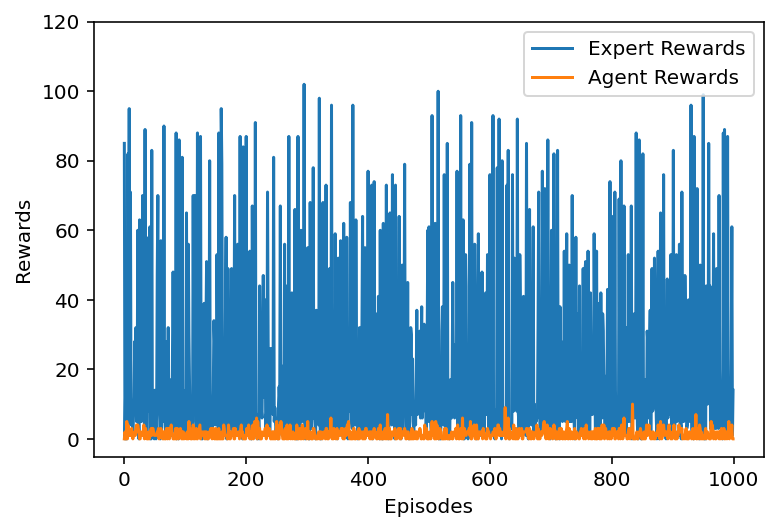

In [6]:
if __name__ == '__main__':
    expert_rewards_list =[]
    agent_rewards_list = []
    expert_rewards_list , agent_rewards_list =  main()
    plt.plot(expert_rewards_list , label='Expert Rewards')
    plt.plot(agent_rewards_list, label='Agent Rewards')
    plt.legend()
    plt.ylim(ymax=120)
    plt.ylabel("Rewards")
    plt.xlabel("Episodes")